# Sentiment Analysis

Three ways to do sentiment analysis:
1. Lexicon/Keyword
2. NLP/ML
3. LLM/Gen-AI
<br>

Lexicon is outdated and NLP or LLM approach is more preferred today.

This notebook will compare the difference between these three method on sentiment analysis

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re

import tensorflow as tf
from keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Dataset

We will be using sentiment140 dataset from https://www.kaggle.com/datasets/kazanova/sentiment140/data for sentiment analysis.

It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet ( 2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)

Cleaning of dataset and exploratory analysis on the dataset

In [2]:
file_path = os.path.join('..', 'Data', 'training.1600000.processed.noemoticon.csv')
sentiment140_data = pd.read_csv(file_path, encoding='latin1', header=None)
sentiment140_data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [3]:
sentiment140_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
sentiment140_data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [5]:
sentiment140_data.describe(include=['object'])

,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


In [6]:
sentiment140_data['ids'].nunique()

1598315

In [7]:
# Remove duplicates
sentiment140_data = sentiment140_data.drop_duplicates(subset=['ids'])
sentiment140_data.reset_index(drop=True, inplace=True)

# We are only using target, text and date, so we can drop other columns
sentiment140_data = sentiment140_data.drop(['ids', 'flag', 'user'], axis = 1)

In [8]:
sentiment140_data.head()

,target,date,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


In [9]:
lab_to_sentiment = {0:"Negative", 2: "Neutral", 4:"Positive"}

def label_decoder(label):
    return lab_to_sentiment[label]

sentiment140_data['target'] = sentiment140_data['target'].apply(lambda x: label_decoder(x))
sentiment140_data.head()

,target,date,text
0,Negative,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,Negative,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,Negative,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,Negative,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

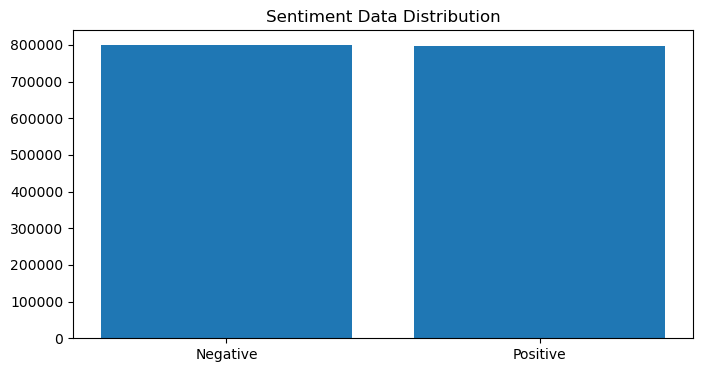

In [10]:
val_count = sentiment140_data.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [11]:
sentiment140_data['date'] = pd.to_datetime(sentiment140_data['date'])
sentiment140_data['date'] = sentiment140_data['date'].dt.date
sentiment_count = sentiment140_data.groupby(['date', 'target']).size().unstack(fill_value=0)

d:\UNI\Application\Anaconda\envs\tf2_cpu\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


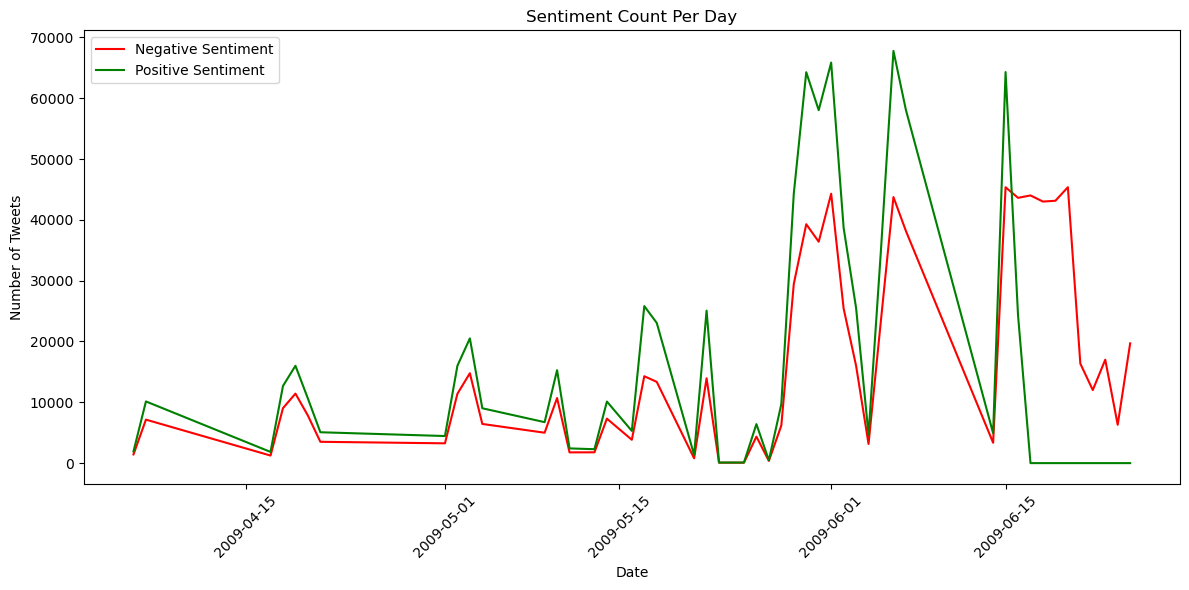

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_count.index, sentiment_count['Negative'], label='Negative Sentiment', color='red')
plt.plot(sentiment_count.index, sentiment_count.get('Positive', 0), label='Positive Sentiment', color='green')

plt.title('Sentiment Count Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We will be doing some text preprocessing to clean the text file. Here we will need to do stemming and lemmatisation. 

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatisation usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

We will also be removing stopwords. Stopwords are commonly used words that does not provide any contextual meaning in a sentence, these are words like, the, a , an ,etc.


We will be using the nltk library to help us clean the text.

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()   
    tokens = []
    
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

sentiment140_data['text'] = sentiment140_data['text'].apply(lambda x: preprocess(x))
sentiment140_data.head()

,target,date,text
0,Negative,2009-04-06,awww bummer shoulda got david carr third day
1,Negative,2009-04-06,upset update facebook texting might cry result...
2,Negative,2009-04-06,dived many times ball managed save 50 rest go ...
3,Negative,2009-04-06,whole body feels itchy like fire
4,Negative,2009-04-06,behaving mad see


The data is now clean and we can begin doing sentiment analysis using the three different apporach

## Lexicon

Lexicon is a dictionary of words with its associated sentiment value, usually a positive value if the sentiment is positive and vice versa. The sentiment analysis is done by comparing the words in the text with the lexicon and determining the sentiment of the overall text. 

In this project, I will be using a lexicon from nltk library called the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon as it is attuned to sentiments expressed in social media and given that our texts are tweets gathered from twitter api, this is what I will be going for.

VADER has some key features which are: 
1. It can directly return a compound value of the sentiment of the text, this is the overall sentiment score, normalised to between -1(Negative Sentiment) to 1 (Positive Sentiment).

2. It is also capable to take into account the preceding word of the current word. This means that words that modify the degree of sentiment is taken into account, i.e., very great will have a more positive sentiment than great


In [14]:
sia = SentimentIntensityAnalyzer()

sentiment140_data['sentiment_lex'] = sentiment140_data['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
sentiment140_data.head()

,target,date,text,sentiment_lex
0,Negative,2009-04-06,awww bummer shoulda got david carr third day,-0.3818
1,Negative,2009-04-06,upset update facebook texting might cry result...,-0.7269
2,Negative,2009-04-06,dived many times ball managed save 50 rest go ...,0.4939
3,Negative,2009-04-06,whole body feels itchy like fire,-0.2500
4,Negative,2009-04-06,behaving mad see,-0.4939


In [15]:
sentiment140_data['sentiment_lex_label'] = sentiment140_data['sentiment_lex'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
sentiment140_data['comparison_lex'] = sentiment140_data['sentiment_lex_label'] == sentiment140_data['target']
sentiment140_data.head()

,target,date,text,sentiment_lex,sentiment_lex_label,comparison_lex
0,Negative,2009-04-06,awww bummer shoulda got david carr third day,-0.3818,Negative,True
1,Negative,2009-04-06,upset update facebook texting might cry result...,-0.7269,Negative,True
2,Negative,2009-04-06,dived many times ball managed save 50 rest go ...,0.4939,Positive,False
3,Negative,2009-04-06,whole body feels itchy like fire,-0.2500,Negative,True
4,Negative,2009-04-06,behaving mad see,-0.4939,Negative,True


In [16]:
accuracy = sentiment140_data['comparison_lex'].mean()
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 63.77%


Looking at the accuracy of the sentiment, we can see that it is not that great. While the VADER lexicon is attuned to social media texts, it is still not powerful enough to properly predict the sentiment of a text. 

Several reasons include:
1. Inability to understand context such as sarcasm and irony. 
2. Dependence on text length, when a sentence is short, some word may make VADER think that a sentence is on the extreme ends of the sentiments, very positive or very negative when its subsequent word may change the sentiment entirely

## NLP/ML

In [17]:
train, test = train_test_split(sentiment140_data, test_size=0.2, random_state=1234567890)

print("Train Data size:", len(train))
print("Test Data size", len(test))

Train Data size: 1278652
Test Data size 319663


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290782


## LLM/Gen-AI